In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import gzip

# Import my packages.
%matplotlib inline
import matplotlib as mpl
%matplotlib notebook
%matplotlib notebook

import sys
from importlib import reload
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/insulators/bin')
from hic_jupyter import viewer
import hic_jupyter as hc

## Ideas

Use some kind of classifier to call short-range boundaries. I like the idea of using protein data in addition to Hi-C, but I can play around with that. I guess I need to make the input data for the genome. Probably start with some smaller section...maybe a single chromosome arm?

Yeah I'll start with 2R just for funsies.

Can imagine two types of Hi-C input. One is the local data, normalized bin-counts plus and minus some window. The other is to derive an insulation score, maybe using multiple windows? I want to play with insulation scores.

In [3]:
reload(hc)
data_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R'
track_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_tracks_reduced'
save_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R'
#hc.viewer(data_folder, track_folder, save_folder, genometracks=False)


OK, how should I start. I need two things:

1. A sample data structure (what data am I including? Insulation scores with various windows and gaps?)  
2. Some training data. Need to pick some section of the genome to hand call boundaries.  

I updated viewer function to store positions of mouse clicks, so that's fine. How do I pick a segment? Actually I think I need to do part one first. Make the genome-wide sample data, then write a function that just matches a set of calls to some bounded genome section for training data.

Since I don't know what I'm doing, let's try learning on the directionality data directly and on the difference (insulation score data). Start with insulation scores.  I generated a decent amount up above... Just need a function to combine.

In [51]:
# make_sample_data loads n viewer tracks for chromosome of m bins and combines into an ndarray of dimensions m,n.
# Note: only works for single chromosome
import gzip
fs = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_20_diff_3_gap_1.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_20_diff_4_gap_1.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_20_diff_5_gap_1.txt.gz'      
        ]

def make_sample_data(files, genome_size, bin_size=500):
    num_bins = int(genome_size // bin_size)
    data = np.zeros((num_bins, len(files)))
    #labels = np.empty((1, num_bins), dtype="int")
    
    for i in range(0, len(files)):
        file = files[i]
        if (file[-2:] == 'gz'):
            f = gzip.open(file, 'rt')
        
        else:
            f = open(files[i], 'r')
        for line in f:
            line = line.rstrip()
            chr_, bin_, val = line.split()
            val = float(val)
            bin_ = int(bin_)
            data[bin_, i] = val

    return data
    

As it currently stands, I could do something complicated to combine chromosomes (not THAT complicated...) but I think I'll just run it on individual chromosomes to make life easier.

Now, to make some training data...

In [5]:
reload(hc)
data_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked'
track_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks'
save_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R'
#hc.viewer(data_folder, track_folder, save_folder)

In [49]:
# Takes a list of coordinates (hand-called boundaries) and output from make_sample_data, returns
# matched data (essentiallly a slice of X_data) and labels (1 where boundary called, 0 elsewhere).

# Only for single chromosome at the moment.

def make_training_data(x, coordfiles, buffer=10, binsize=500):
    def process_coordfile(x, coordfile, buffer, binsize):
        y = np.zeros((x.shape[0]))
        min_ = np.inf
        max_ = -np.inf
        
        f = open(coordfile, 'r')
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                pass
            else:
                chr_, pos1, pos2 = line.split()
                pos1 = float(pos1)
                pos2 = float(pos2)
                pos = np.mean([pos1, pos2]) * 1e6
                bin_ = int(pos / binsize)
                if (bin_ < min_):
                    min_ = bin_
                if (bin_ > max_):
                    max_ = bin_
                y[bin_] = 1
        training_data = x[(min_ - buffer):(max_ + buffer), :]
        class_labels = y[(min_ - buffer):(max_ + buffer)]
        f.close()
        return training_data, class_labels
    
    data, labels = process_coordfile(x, coordfiles[0], buffer, binsize)
    for i in range(1, len(coordfiles)):
        new_data, new_labels = process_coordfile(x, coordfiles[i], buffer, binsize)
        data = np.vstack((data, new_data))
        labels = np.hstack((labels, new_labels))
    
    return data, labels    

<IPython.core.display.Javascript object>


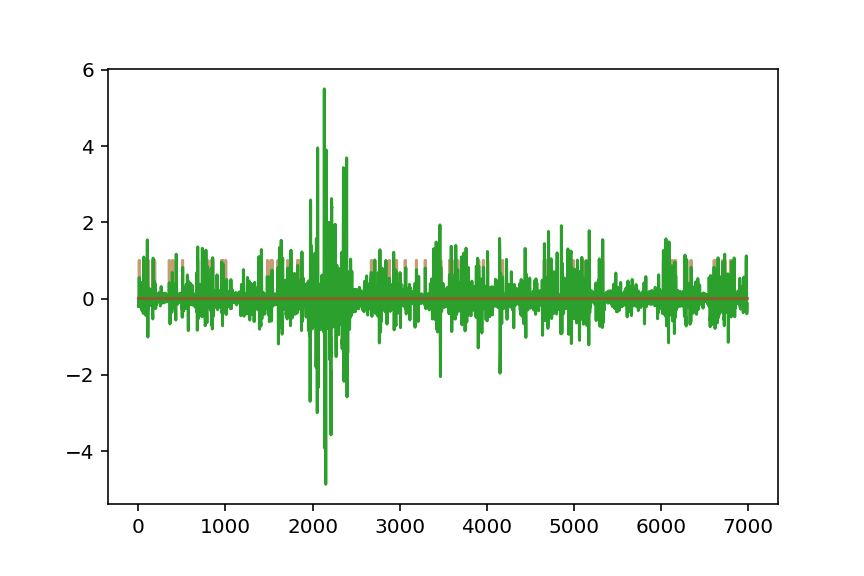

In [235]:
b = b.astype(float)
b1 = np.vstack((b,b))
b1 = b1.T

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(b1,b1[:,0])
c = clf.predict(b1)
plt.plot(b, alpha=0.5)
plt.plot(c, alpha=0.5)

<IPython.core.display.Javascript object>


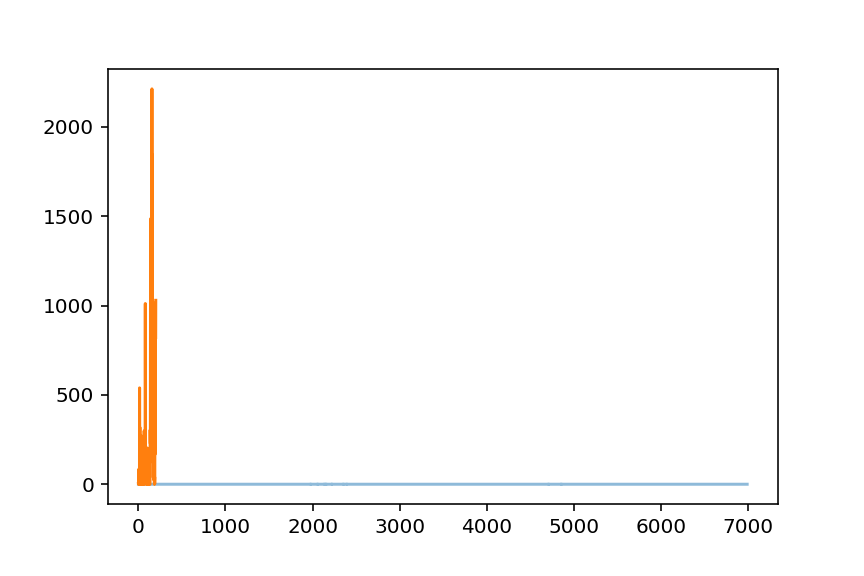

In [245]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(200, 100))
a = a - np.min(a)
clf.fit(a,b)
c = clf.predict(a)
#plt.plot(b, alpha=0.5)
#plt.plot(a[:,2])
plt.plot(c, alpha=0.5)

## Intermediate: Mask low-visibility regions.

I could do it in a principled way but I'll just use an HMM on the Hi-C coverage data (at least I'll try).

<ins> Things learned: <ins>
    1. With the raw data, it does a pretty good job, but it has the problem of doing these little state switches within dead blocks. There are at least two ways to fix this. (1) Adding a high-pass threshold (set everything below n to 0) makes the HMM work pretty well, but then I wonder whether I should just use the straight threshold for masking. (2) Could do some post-hoc cleanup to remove short blocks/merge large blocks. I guess I could also find a way to force some of the HMM parameters? Not sure how to go about that.

1. With the raw data what in the hell

In [246]:
from hmmlearn import hmm

NameError: name 'data' is not defined

In [333]:
# Load 1D coverage data.
def load_track_data(trackfile_path):
    """Load genomic track data."""
    track_binsize = 500
    track_data = {}
    with gzip.open(trackfile_path, 'rt') as infile:
        for line in infile:
            items = line.split()
            (chr_, bin_, val) = items
            chr_ = re.sub('chr', '', chr_)
            if (chr_ not in track_data):
                track_data[chr_] = np.zeros(int(1e8 / 500))
            bin_ = int(bin_)
            if (bin_ < len(track_data[chr_])):
                track_data[chr_][bin_] = float(val)
    return track_data

data = load_track_data('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_tracks_reduced/53-54_1dBinCounts.txt.gz')

In [408]:
# Make a 2-state hidden markov model.
#transmat_prior=np.array([[0,1],[1,0]])
input_data = data['2R'].copy()
#input_data[input_data < 100] = 0
#input_data[input_data > 200] = input_data[input_data > 200] * 10

mod = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, transmat_prior=transmat_prior)
data_inshape = input_data.reshape(-1,1)
mod.fit(data_inshape)
mod.means_ = np.array([[0], [1749]])
mod.covars_ = np.array([[[1000]], [[1.08775478e+06]]])
Z = mod.predict(data_inshape)


In [409]:
transmat_prior=np.array([[0,1],[1,0]])
f = open('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/mask1000.txt', 'w')
for i in range(0, int(1e5)):
    val = str(Z[i])
    bin_ = str(i)
    f.write('2R\t' + bin_ + '\t' + val + '\n')

GridspecLayout(children=(Dropdown(description='Chrom', layout=Layout(grid_area='widget001'), options=('2R',), …

<IPython.core.display.Javascript object>


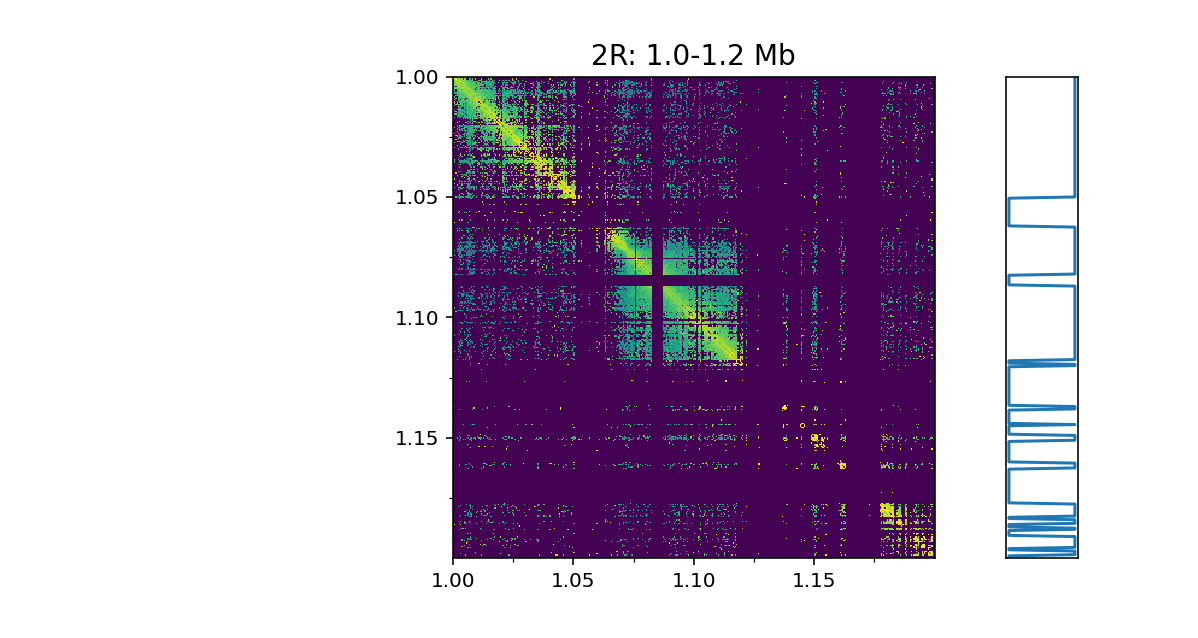

In [410]:
hc.viewer(data_folder, track_folder, save_folder)

In [354]:
input_data = data['2R'].copy()
#input_data[input_data < 100] = 100
#input_data[input_data > 200] = input_data[input_data > 200] * 10

mod = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, transmat_prior=transmat_prior)
mod.means_ = np.array([[100], [1749]])
data_inshape = input_data.reshape(-1,1)
mod.fit(data_inshape)

GaussianHMM(covariance_type='full', n_components=2, n_iter=1000,
            transmat_prior=array([[0, 1],
       [1, 0]]))

### Midpoint update

This problem is far from solved, but it seems like the HMM works pretty well as long as I manually set the variance for the masked state to be higher. It seems that the fit algorithm has the variance converge to basically 0 which means that dead blocks that have a stray non-zero bin in the middle will get discontinuities. This seems remediable by just setting the variance after fitting to be something larger, and in fact it seems that setting is quite high (as high as 1000, with the mean of the non-masked space only 1700) does a nice job. I think normalizing the data (so other datasets with different read depths will work) should be a good strategy. Again, this doesn't have to be perfect, just a reasonable way to mask away dead spots that is accurate enough.

#### Interesting idea:
If thresholding becomes necessary, using image-processing threshold algorithms (Otsu) would probably work very well for this problem. 

OK, so what's the plan? Should I make masked versions of the viewer panels? Or implement masking in 1D and correct the insulation maps...leaning toward the latter. Nope, changed my mind. There are advantages to working with masked viewer files as well...let's mask the viewer files.


In [431]:
a = np.array([1,2,3,np.nan])

In [435]:
np.nanmean(a)

2.0

### UGGGGGH

So I think masking is still useful and I'll finish up these things at some point (probably soon). But I realize that the problem with the dead regions is that I replaced them with 0.5 in the directionality script. Because 0.5 is much lower than the average signal, this meant all regions to the left of a dead region have huge leftward biases, all the regions to the right have huge rightward biases, and within them the bias is around 0, giving a big change still. 

An interesting thing is the dead region are effectively masked already: they're nan because one of the involved bins had 0 counts (giving nan from normalization). I played around with the idea of using like 'm' for masked regions or something, but really using nan for masking is the most sensible thing. So the only thing masking would accomplish would be to remove the "stray" pixels in otherwise dead regions. This is certainly a useful thing to do, and I should do it. But it probably isn't necessary to fix the directionality/boundary problem--I just need to handle nans better.

So a quick fix is to not replace the nans and to use np.nanmean for the window means. I wonder if I should also do some kind of thing where if a certain fraction of the values are nan I just nix the score...ok yes I did this, currently using 50% of the window length as the cutoff.

In [8]:
import re
import os

def boundary_score(infolder, outfilepath, windowsize, binsize, difference=False, diff_window=2, gap=1, nan_buffersize=10):
    def rolling_diff(x, diff_window, gap):
        diff = x.copy()
        for i in range(diff_window, len(x) - diff_window + 1):
            diff[i] = np.mean(x[(i+gap):(i+diff_window)]) - np.mean(x[(i-diff_window):(i-gap)])
        return diff
    
    def not_valid_file(filename):
        if (re.search('txt.gz', filename)):
            name_items = re.sub('.txt.gz', '', filename)
            if (len(name_items.split('_')) == 4):
                return False
        return True
    
    def add_panel(infolder, filename, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize):
        min_nonnan = 0.5 * nan_buffersize
        if not_valid_file(filename):
            return
        x = np.genfromtxt(os.path.join(infolder, filename))
        #x[np.isnan(x)] = 0.5
        x[x == 0] = 0.5
        
        name_items = re.sub('.txt.gz', '', filename)
        chr_, start, end, file_binsize = name_items.split('_')
        start_bin = int(int(start) / binsize)
        end_bin = int(int(end) / binsize)
        
        if (int(file_binsize) == binsize):
            if (chr_ not in scores):
                scores[chr_] = np.zeros(chr_max_bins)
            if (chr_ not in chr_maxes):
                chr_maxes[chr_] = end_bin
            if (end_bin > chr_maxes[chr_]):
                chr_maxes[chr_] = end_bin
                
            panel_size_bins = end_bin - start_bin
            for n in range(windowsize, panel_size_bins - windowsize + 1):
                left_window = x[n, (n-windowsize):n]
                right_window = x[n, (n+1):(n+windowsize+1)]
                if ((np.count_nonzero(~np.isnan(left_window[(-1 * nan_buffersize):])) > min_nonnan) and
                    (np.count_nonzero(~np.isnan(right_window[:nan_buffersize])) > min_nonnan)):
                    mean_left = np.nanmean(left_window)
                    mean_right = np.nanmean(right_window)
                    logratio = np.log(mean_right / mean_left)
                    genome_bin = start_bin + n
                    scores[chr_][genome_bin] = logratio
    chr_max_size = 1e8
    chr_max_bins = int(chr_max_size // binsize)
    chr_maxes = {}
    scores = {}
    files = os.listdir(infolder)
    
    for file in files:
        add_panel(infolder, file, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize)
        
    outfile = open(outfilepath, 'w')
    for chr_ in chr_maxes.keys():
        if difference:
            scores[chr_] = rolling_diff(scores[chr_], diff_window, gap)
        
        for bin_ in range(0, chr_maxes[chr_]):
            score = scores[chr_][bin_]
            if (score != 0):
                outfile.write(chr_ + '\t' + str(bin_) + '\t' + str(score) + '\n')
    outfile.close()

In [ ]:
hc.viewer(data_folder, track_folder, save_folder)

In [ ]:
fs = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_20_diff_3_gap_1.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_20_diff_4_gap_1.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_20_diff_5_gap_1.txt.gz'      
        ]

After looking through some of these data, I actually think masking is a good idea. Though I suspect it can be done more easily using restriction site frequency data directly, rather than inferring it from the data? Or perhaps not...will have to see.

I'll make a viewer track of AATT frequency and see how that does:

In [24]:
from Bio import SeqIO
import re

outfile = open('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/AATT_count.txt','w')

for record in SeqIO.parse("/Users/michaelstadler/Bioinformatics/reference/dm6.fa", "fasta"):
    chr_ = re.sub('chr', '', record.id)
    if (chr_ in ['2L', '2R', '3L', '3R', '4', 'X']):
    #if (chr_ == '4'):
        max_bin = int(len(record.seq) / 500)
        for bin_ in range(0, max_bin):
            start = bin_ * 500
            end = start + 500
            #bin_seq = record.seq[start:end]
            count = record.seq.count('AATT', start, end)
            if (count > 0):
                outfile.write(chr_ + '\t' + str(bin_) + '\t' + str(count) + '\n')
            
outfile.close()

GridspecLayout(children=(Dropdown(description='Chrom', layout=Layout(grid_area='widget001'), options=('2R',), …

<IPython.core.display.Javascript object>


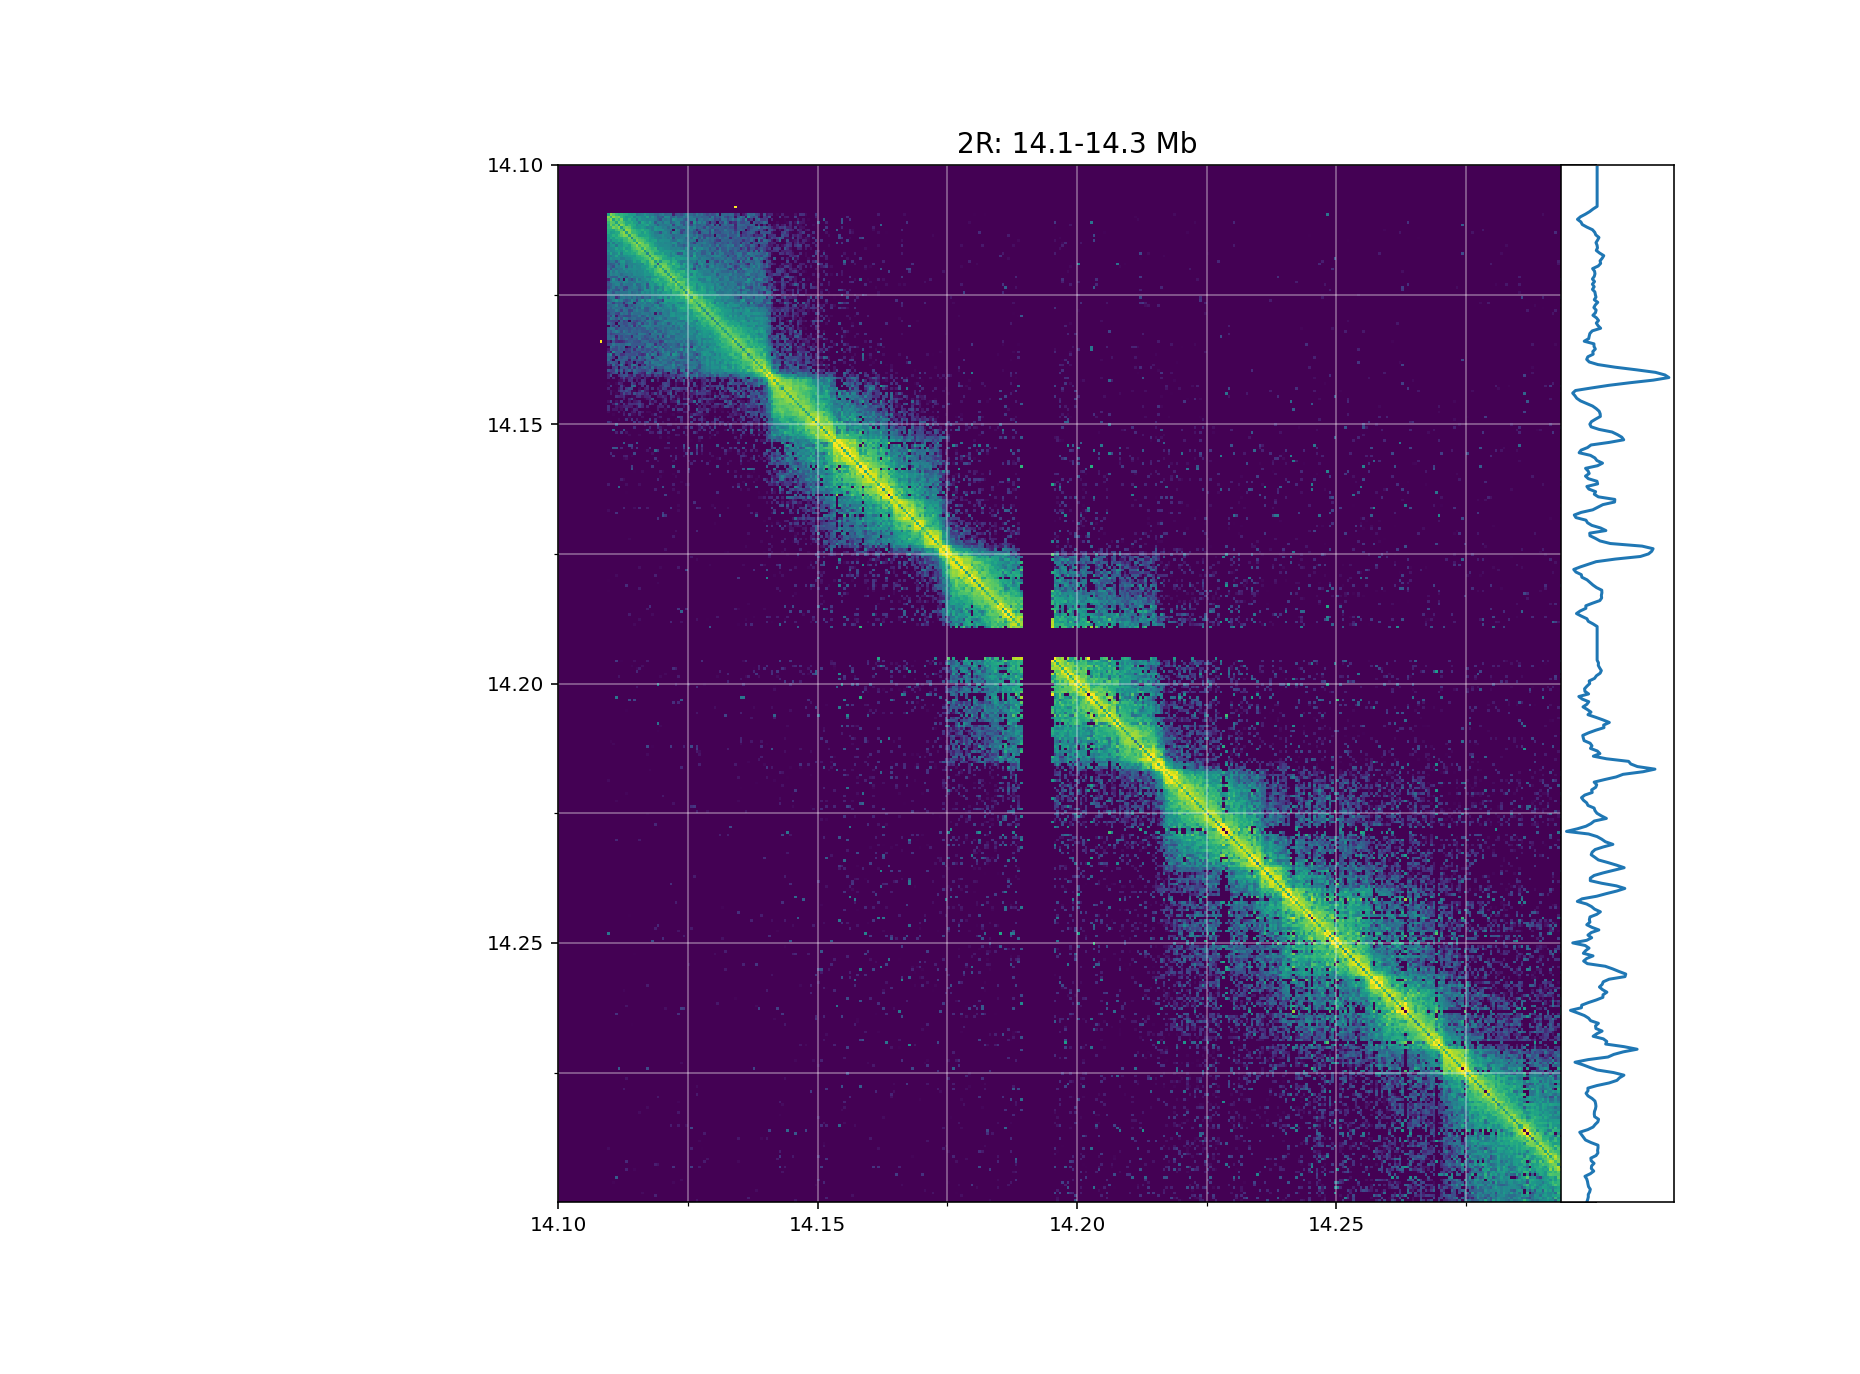

In [6]:
hc.viewer(data_folder, track_folder, save_folder)

Ok this is interesting and informative. The AATT-free regions account for some but not all of the drops. The others, of course, are due to repeats (unmappable). It seems that one could simulate reads to produce some kind of experiment-free means of capturing the requirement for the digest + mappable requirement. Is this worth it? Could be...

Shouldn't be too hard. Sure I'll tackle it because I'm a fool.

I ended up doing a separate notebook on masking genomes. It's called __20210121-masking-melanogaster-genome.ipynb__. Uses a simple HMM and it seems to work pretty well.

OK, back to work with masked data...

In [55]:
# Redo the insulation scores using the masked input files.

infolder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked'
for w in [75]:
    for n in [1,2,3,6,7,8,9,10]:
        for g in range(0, 1):
            if (n > g):
                outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_' + str(w) + '_diff_' + str(n) + '_gap_' + str(g) + '.txt'
                boundary_score(infolder, outfile, w, 500, True, n, g)

In [2]:
hc.viewer(data_folder, track_folder, save_folder)

NameError: name 'data_folder' is not defined

# What have we learned

So using larger windows for computing directionality seems good. I didn't see any benefit between 75 and 100, however, so the effect seems to plateau. I'm not sure whether this is surprising or not. Because the value is effectively a sum (mean), the score will be dominated by diagonal-proximal (intra-TAD, if you will) signal anyway. Adding more bins beyond that shouldn't do a whole lot. Then again, a range of 75 is only 37.5 kb, so perhaps that is just a nice range to get as much diagonal-proximal information as you can and smaller values are tossing some intra-TAD data. Unclear.

Adding a "gap" doesn't seem to accomplish anything other than needlessly widening peaks. 

The toughest thing was handling low-visibility regions. First, I masked these regions. This still gave me some strange effects at some (not all) regions adjacent to the masked regions that I honestly still don't fully understand. Sometimes dips, sometimes rises...I'm sure I could figure it out but I went ahead an implemented an nan_buffersize. Default is set at 10, so when computing insulation scores, at least 50% of the 10 adjacent bins on the left and right have to be non nan. This effectively squelches the scores in the immediate vicinity of these masked regions. Perhaps a bit clusmy, but effective.

It's not clear which of these resulting scores, different only by the "difference window" (the size of the windows used for taking the derivative) is most effective. It doesn't seem like anything below around 5 will be of any use. Proof will be in the pudding...

On to calling boundaries out of this data!

# Back to learning

In [4]:
# Make sample data matrix.

def make_sample_data(files, genome_size, bin_size=500):
    num_bins = int(genome_size // bin_size)
    data = np.zeros((num_bins, len(files)))
    
    for i in range(0, len(files)):
        file = files[i]
        if (file[-2:] == 'gz'):
            f = gzip.open(file, 'rt')
        
        else:
            f = open(files[i], 'r')
        for line in f:
            line = line.rstrip()
            chr_, bin_, val = line.split()
            val = float(val)
            bin_ = int(bin_)
            data[bin_, i] = val

    return data

In [5]:
# Takes a list of coordinates (hand-called boundaries) and output from make_sample_data, returns
# matched data (essentiallly a slice of X_data) and labels (1 where boundary called, 0 elsewhere).

# Only for single chromosome at the moment.

def make_training_data(x, coordfiles, buffer=10, binsize=500):
    def process_coordfile(x, coordfile, buffer, binsize):
        y = np.zeros((x.shape[0]))
        min_ = np.inf
        max_ = -np.inf
        
        f = open(coordfile, 'r')
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                pass
            else:
                chr_, pos1, pos2 = line.split()
                pos1 = float(pos1)
                pos2 = float(pos2)
                pos = np.mean([pos1, pos2]) * 1e6
                bin_ = int(pos / binsize)
                if (bin_ < min_):
                    min_ = bin_
                if (bin_ > max_):
                    max_ = bin_
                y[bin_] = 1
        training_data = x[(min_ - buffer):(max_ + buffer), :]
        class_labels = y[(min_ - buffer):(max_ + buffer)]
        f.close()
        return training_data, class_labels
    
    data, labels = process_coordfile(x, coordfiles[0], buffer, binsize)
    for i in range(1, len(coordfiles)):
        new_data, new_labels = process_coordfile(x, coordfiles[i], buffer, binsize)
        data = np.vstack((data, new_data))
        labels = np.hstack((labels, new_labels))
    
    return data, labels    


In [62]:
call_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/clickedcoords_2021-01-07-4.txt',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2.txt',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_3_clickedcoords_2021-01-07-10.txt'
        ]

data_files = [
    '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_1_gap_0.txt.gz',
    '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_2_gap_0.txt.gz',
    '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_3_gap_0.txt.gz',
    '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_4_gap_0.txt.gz',
    '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_5_gap_0.txt.gz',
]

X_data = make_sample_data(data_files, 9e7)

t_data, t_labels = make_training_data(X_data, files)

<IPython.core.display.Javascript object>


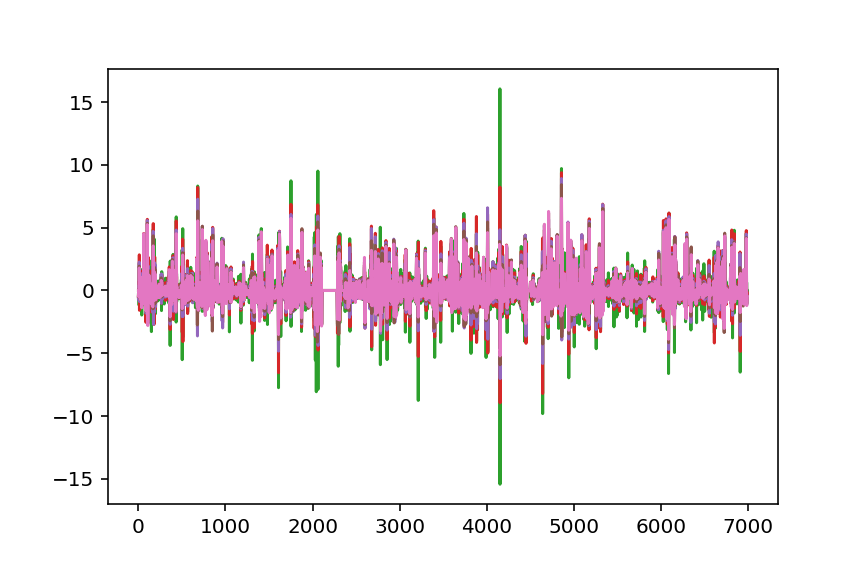

In [176]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
data = t_data[:,:].copy()
labels = t_labels.copy()
#data[labels.astype(bool)] = data[labels.astype(bool)] * 3
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)
#data = (data - np.min(data))

clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(1, 2), alpha=1e-15)
clf.fit(data, labels)
c = clf.predict(data)
plt.plot(labels, alpha=0.5)
#plt.plot(data, alpha=1)

plt.plot(c, alpha=0.5)

In [150]:
from sklearn.neural_network import MLPClassifier
a = 1
b = -0.1
data = np.array([a,b,b,b,a,b,a,b,b,b,b,a])
data = data.reshape(-1,1)
labels = np.array([1,0,0,0,1,0,1,0,0,0,0,1])
clf = MLPClassifier(solver='lbfgs', alpha=1, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(data, labels)
c = clf.predict(data)
#plt.plot(labels*4, alpha=0.5)
#plt.plot(data, alpha=1)

plt.plot(c, alpha=0.5)

## Thoughts

This has been fun, but I realize that this is not the correct approach. This machine learning style is treating each bin as an independent feature, but actually there's spatial correlation (peaks may consist of several adjacent bins). There's also a modest issue of some of the hand-called peaks not being exactly centered on insulation peaks...this can be fixed through nudging. I could use a different approach -- more of a peak-calling approach, or I could clean up the hand calls, nudging them onto local maxima and including adjacent bins where needed. Happily, it appears that most of the boundaries are very sharp, 1-2 bins, so this isn't a terrible difficult problem. 

The larger problem persists, though. The machine learning on one dataset would be no better than a threshold (since information from adjacent bins aren't considered). It could still be useful because it can include data from multiple data inputs (different parameters, eventually protein, etc.). But by reducing it to a 1D data type it does beg for an HMM-based approach. How do I train an HMM with a training set?

OK I spent some time looking at this. I'm going to try working with a package called pomegranate. It contains a number of probabilistic modeling functions through an easy-to-use API, and seems to have an implementation of supervised and semi-supervised HMMs. 

It seems that the first task is to make some new data. The way they encode labeling (a scikit learn convention) is to assign unlabeled features -1. So I'll make the data for all of chr2R, with the training regions getting their proper labels and everything else getting -1. I'm not entirely sure what the data need to look like, though, so I think I'll start with doing some example stuff.

In [249]:
from pomegranate import *

In [285]:
?pg.HiddenMarkovModel.from_samples

In [351]:
d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State(d1, name='background')
s2 = State(d2, name='CG island')

model = HiddenMarkovModel()
model.add_states(s1, s2)

model.add_transition(model.start, s1, 0.5)
model.add_transition(model.start, s2, 0.5)
model.add_transition(s1, s1, 0.9)
model.add_transition(s1, s2, 0.1)
model.add_transition(s2, s1, 0.1)
model.add_transition(s2, s2, 0.9)

model.bake()

seq = numpy.array(list('CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'))

hmm_predictions = model.predict(seq)

print("sequence: {}".format(''.join(seq)))
print("hmm pred: {}".format(''.join(map( str, hmm_predictions))))

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 111111111111111000000000000000011111111111111110000


In [346]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.datasets import make_blobs
X, y = make_blobs(1000, 2, 2, cluster_std=2)
x_min, x_max = X[:,0].min()-2, X[:,0].max()+2
y_min, y_max = X[:,1].min()-2, X[:,1].max()+2


In [415]:
y1 = np.array([y,y,y,y]).T
h = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X], labels= [y])
#h
#HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 3, [X])
h.sample(length=20)

array([[  1.06658921,  -5.74928179],
       [ -9.19303528,  -1.17375786],
       [-13.65514554,  -5.66027026],
       [ -6.9951265 ,  -2.99929813],
       [  5.45674282,  -2.34997073],
       [ -9.1926454 ,  -4.00727878],
       [-11.42871815,  -4.0067939 ],
       [ -8.3836574 ,  -0.91752869],
       [  5.11029704,  -1.3746832 ],
       [  8.00182161,  -0.05323194],
       [ -7.54479561,  -5.46156718],
       [-10.48099322,  -1.30484868],
       [  3.69835084,  -2.66051597],
       [-10.65750685,  -6.27568883],
       [  3.87417565,   1.18852917],
       [  3.3655883 ,  -2.27239355],
       [ -7.38931269,  -9.11059801],
       [ -6.54192916,  -4.66482129],
       [ -6.73075407,  -3.57982023],
       [ -9.07733581,  -0.75152   ]])

So I struggled with this a lot. I gave it NormalDistribution and couldn't get it to do a multivariate model when using labels (an n by 4 input produced an n by 1 output). Interestingly, this works if you don't give it labels. Anyway, the solution (above) is to use a multivariate distribution. This does the job.

** Saving this from github discussion in case it's ever useful (doesn't seem to be correct currently): From github discussion about some issues: "I had the same issue. It turns out that the labels parameter to the fit function should be a list of actual HMM states (not labels or indices). In your case, that would be something like [s0, s0, s2, s1]. This isn't really clear in the documentation and being able to reference the states by label makes more sense in my opinion.". Unclear if this is still true...

This will work on my data. If I have a vector of data and some labels, I can call this function and it should (?) fit an HMM. Time to get that data in shape!

Need to do:
   
- Nudge hand-calls onto local maxima and extend to include adjacent points if needed. This doesn't need to be terribly principled since it's just using hand calls. Just do the job.

- Figure out how to structure for both supervised (separate out training set) and semi-supervised (assign -1 to all bins outside hand-called regions).

In [547]:
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_3_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_4_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_5_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_6_gap_0.txt.gz']
X = make_sample_data(files, 9e7)

In [6]:
# Take hand-called coordinates and an insulation score data file, re-assign boundary 
# to local peak bin (if necessary) and also to adjacent bins if needed, return label
# array with bins in the hand-called areas labels 0 (not boundary) or 1 (boundary)
# and all other positions -1.

def labels_from_hand_calls(coord_files, ins_data, outfile, adjacent=2, stringency=0.66, binsize=500):
    labels = np.repeat(-1, ins_data.shape[0])
    for coordfile in coord_files:
        f = open(coordfile, 'r')
        bin_min = np.inf
        bin_max = -np.inf
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                pass
            else:
                chr_, pos1, pos2 = line.split()
                pos1 = float(pos1)
                pos2 = float(pos2)
                pos = np.mean([pos1, pos2]) * 1e6
                bin_ = int(pos / binsize)
                if (bin_ > bin_max):
                    bin_max = bin_
                if (bin_ < bin_min):
                    bin_min = bin_
                    
                window_start = bin_ - adjacent
                window_end = bin_ + adjacent
                local_max = np.max(ins_data[window_start:(window_end+1)])
                thresh = local_max * stringency
                for i in range(window_start, window_end+1):
                    val = ins_data[i]
                    if (val >= thresh):
                        labels[i] = 0
        labels[bin_min:(bin_max+1)] += 1         
        f.close()
    return labels


In [446]:
c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_1.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_3_clickedcoords_2021-01-07-10.txt']
y = labels_from_hand_calls(c_files, X[:,2], '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_1_nudged.txt', adjacent=4)

<IPython.core.display.Javascript object>


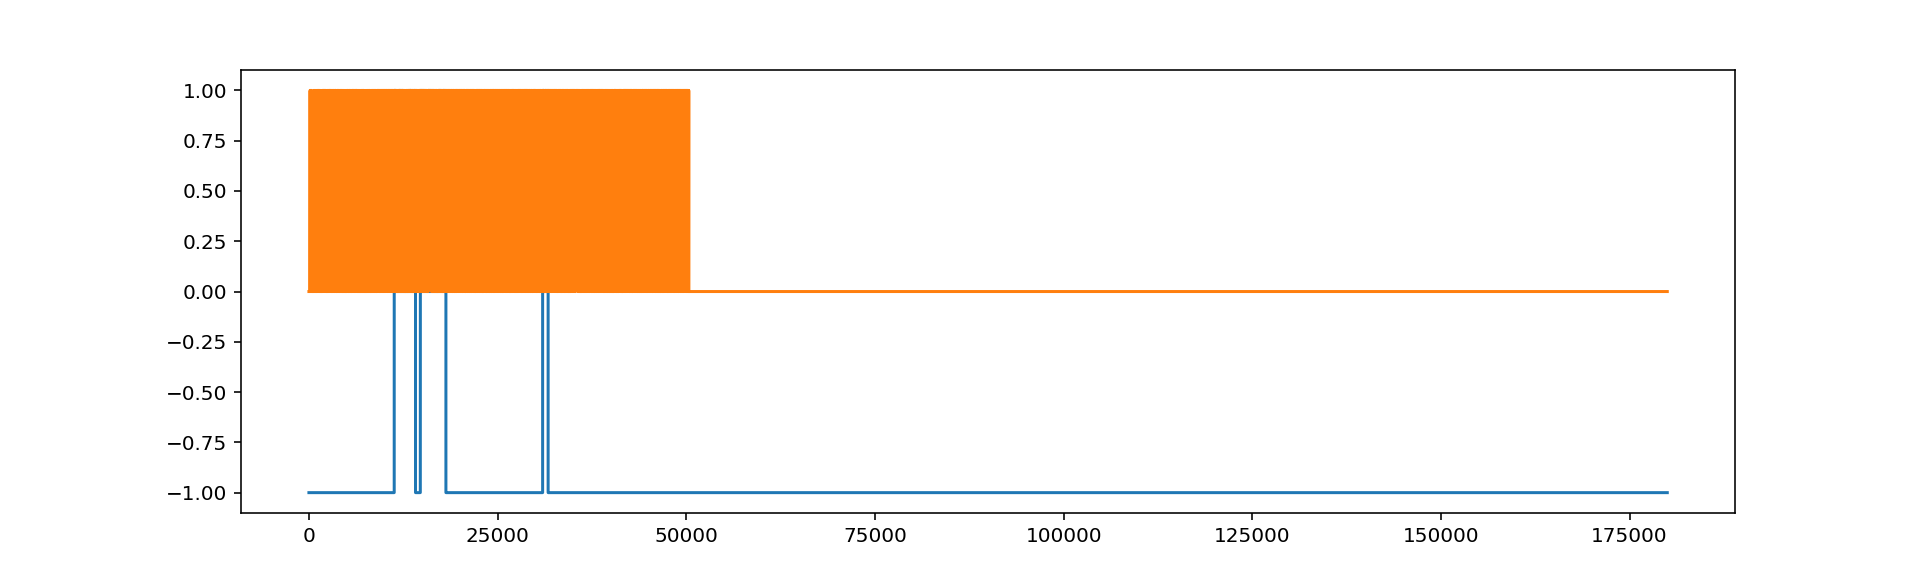

So it turns out semi-supervised learning for HMMs in pomegranate works differently than the others. You can't just supply -1 for all the unlabeled regions -- it throws an error saying it is a 2 state model but got 3 labels. In the documentation, it explains that for HMMs, it works on a sequence level. So you have to give it some sequences with corresponding labels and some sequences without (supplying None for those). The algorithm then does semi-supervised learning on a sequence basis. 

Also, a couple necessary things:
- state labels must be strings
- you must supply the state names for semi-supervised

In [491]:
y2 = y.copy()
y2 = y2.astype(str)
labeled = y2 != '-1'

# Semi-supervised.
h = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X[~labeled], X[labeled]], 
                                   labels= [None, y2[labeled]], state_names=['0','1'])

In [513]:
h

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "MultivariateGaussianDistribution",
                "parameters" : [
                    [
                        -0.0020175528517359883,
                        -0.0024233891494591566,
                        -0.0027658547693915356,
                        -0.0030720933303333936
                    ],
                    [
                        [
                            0.003082934422312888,
                            0.002710803831893099,
                            0.002330860542483934,
                 

In [534]:
o_semi = h.predict(X)

In [514]:
h_sup = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

In [516]:
h_sup

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "MultivariateGaussianDistribution",
                "parameters" : [
                    [
                        -0.031445420954674994,
                        -0.041529974484706175,
                        -0.05169533572000848,
                        -0.06136876025099015
                    ],
                    [
                        [
                            0.010211091025047532,
                            0.009370390726824772,
                            0.008754416388250438,
                       

In [535]:
o_sup = h_sup.predict(X)

<IPython.core.display.Javascript object>


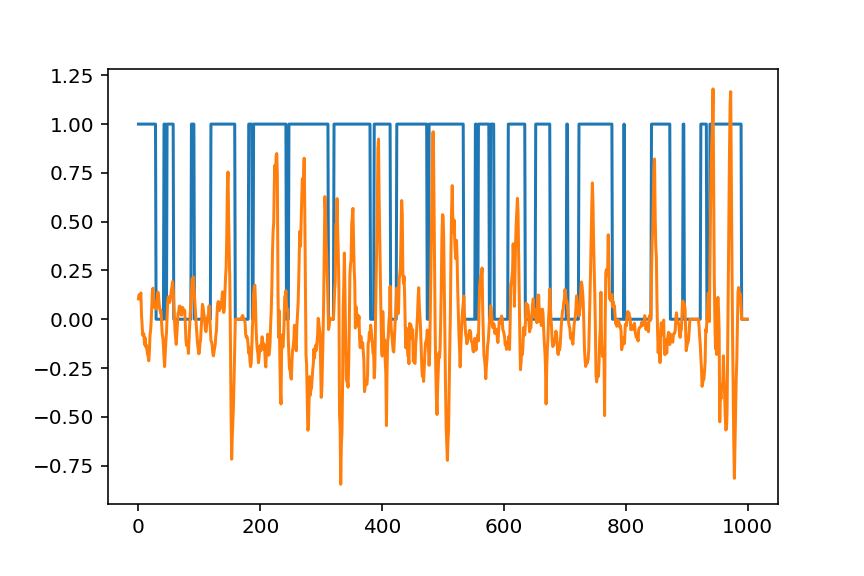

In [539]:
plt.plot(o_semi[13000:14000])
plt.plot(X[13000:14000,3])

<IPython.core.display.Javascript object>


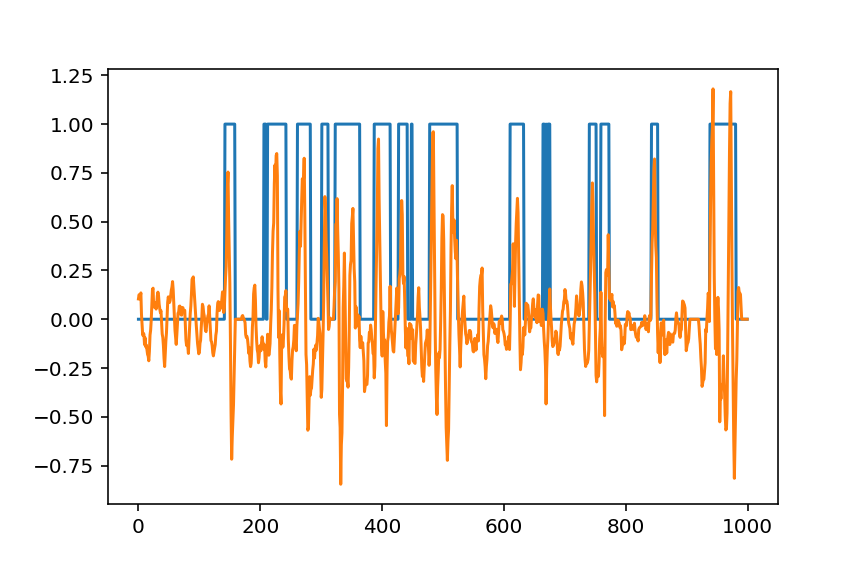

In [542]:
plt.plot(o_sup[13000:14000])
plt.plot(X[13000:14000,3])

Hey! This sorta works-ish. That's something!

On this first pass, the supervised approach certainly looks better, but this isn't cooked at all. What's the thing to do? Maybe try a few tricks and just see how it looks compared to the inputs?

In [4]:
from pomegranate import *
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_1_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_2_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_3_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_4_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_5_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_6_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_7_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_8_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_9_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_10_gap_0.txt.gz'
        ]
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_1.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_3_clickedcoords_2021-01-07-10.txt']
y = labels_from_hand_calls(c_files, X[:,2], '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_1_nudged.txt', adjacent=4)
y2 = y.copy()
y2 = y2.astype(str)
labeled = y2 != '-1'

NameError: name 'make_sample_data' is not defined

In [3]:
X.shape

NameError: name 'X' is not defined

In [2]:
X2 = X.copy()[:,5:6]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

NameError: name 'X' is not defined

In [ ]:
X2 = X.copy()[:,]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

In [545]:
X

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])